In [9]:
import Cortex202306
import AdvRBMs
import Makie
import CairoMakie
import RestrictedBoltzmannMachines as RBMs

using Random: bitrand
using LinearAlgebra: norm
using CudaRBMs: cpu, gpu
using CenteredRBMs: center, uncenter, CenteredRBM
using StandardizedRestrictedBoltzmannMachines: standardize
using RestrictedBoltzmannMachines: mean_h_from_v, sample_v_from_v, free_energy, sample_from_inputs,
    sample_h_from_v, inputs_h_from_v, mode_h_from_v
using Optimisers: Adam
using Statistics: mean, cov
using ProgressMeter: @showprogress
using EllipsisNotation: (..)
using MiniLoggers: global_logger, MiniLogger
global_logger(MiniLogger());

In [3]:
Base.active_project()

"/DATA-SSD/cossio/projects/Cortex/jupyter/20230612_adv/Project.toml"

In [4]:
# put batch dimension at the end following Julia convention
data = Cortex202306.cortex_data_20230607();

In [5]:
neuron_data = data[1:45,:];
spontaneous_label = data[58,:];
movement_label = data[59,:];

In [6]:
# two q's for the two lables
q1 = AdvRBMs.calc_q(spontaneous_label, neuron_data);
q2 = AdvRBMs.calc_q(movement_label, neuron_data);

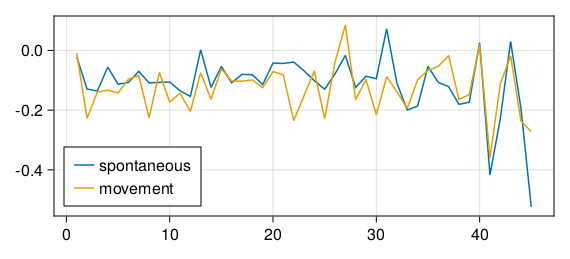

In [11]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=500, height=200)
Makie.lines!(ax, vec(q1) / norm(q1), label="spontaneous")
Makie.lines!(ax, vec(q2) / norm(q2), label="movement")
Makie.axislegend(ax, position=:lb)
Makie.resize_to_layout!(fig)
fig

# Train AdvRBM

In [12]:
adv = RBMs.RBM(RBMs.Binary((45,)), RBMs.xReLU((20,)), zeros(45, 20))
RBMs.initialize!(adv, neuron_data);
adv = gpu(standardize(adv));

In [13]:
function callback(; rbm, iter, _...)
    if iszero(iter % 300)
        Δt = @elapsed (lpl = mean(RBMs.log_pseudolikelihood(cpu(rbm), cpu(neuron_data))))
        @info iter lpl Δt
    end
end

callback (generic function with 1 method)

In [17]:
AdvRBMs.advpcd!(
    # model
    adv,
    
    # data
    gpu(neuron_data);
    
    # "adversarial" constraint
    qs = [gpu(q2), gpu(q1), gpu(cat(q1, q2; dims=2))],
    ℋs = [
        CartesianIndices((1:1,)),
        CartesianIndices((2:2,)),
        CartesianIndices((3:length(adv.hidden),))
    ],
    
    # training hyper-parameters
    batchsize = 256,
    iters = 50000,
    steps = 50,
    optim = Adam(5f-4),
    
    # regularization
    l2l1_weights = 0.01,
    
    # A function that gets called with every gradient update
    callback,

    # parameters controlling the hidden unit statistics normalization
    ϵv=1f-1, ϵh=0f0, damping=1f-1,
)

[2023-06-23 19:08:15] Info: 300 lpl = -0.08543096, Δt = 2.609550088
[2023-06-23 19:08:21] Info: 600 lpl = -0.085548274, Δt = 0.193959337
[2023-06-23 19:08:26] Info: 900 lpl = -0.082293905, Δt = 0.19086144
[2023-06-23 19:08:32] Info: 1200 lpl = -0.085325114, Δt = 0.184027789
[2023-06-23 19:08:37] Info: 1500 lpl = -0.085300095, Δt = 0.180817971
[2023-06-23 19:08:42] Info: 1800 lpl = -0.09022201, Δt = 0.176903572
[2023-06-23 19:08:48] Info: 2100 lpl = -0.090865225, Δt = 0.171006167
[2023-06-23 19:08:53] Info: 2400 lpl = -0.08559118, Δt = 0.19760827
[2023-06-23 19:08:59] Info: 2700 lpl = -0.081293136, Δt = 0.186322295
[2023-06-23 19:09:04] Info: 3000 lpl = -0.081439994, Δt = 0.232503265
[2023-06-23 19:09:10] Info: 3300 lpl = -0.08071303, Δt = 0.230234914
[2023-06-23 19:09:15] Info: 3600 lpl = -0.082394116, Δt = 0.235697026
[2023-06-23 19:09:21] Info: 3900 lpl = -0.08526139, Δt = 0.217191226
[2023-06-23 19:09:26] Info: 4200 lpl = -0.07884826, Δt = 0.209198432
[2023-06-23 19:09:32] Info: 450

((visible = Leaf(Adam{Float32}(0.0005, (0.9, 0.999), 1.19209f-7), (Float32[0.000905927 -0.000227861 … -0.00161194 0.00229708], Float32[3.86075f-5 7.97922f-5 … 9.72643f-5 0.000186143], (6.0f-45, 1.88044f-22))), hidden = Leaf(Adam{Float32}(0.0005, (0.9, 0.999), 1.19209f-7), (Float32[-0.000883886 0.0011045 … 0.00248301 0.00359882; 0.00497028 0.00284294 … 0.00136347 -0.00167791; -0.00419327 -0.00324762 … -0.00121071 0.000930999; -0.0155168 -0.00403848 … 0.00112995 0.000420774], Float32[0.00412758 0.00395795 … 0.000446192 0.000323094; 0.000192946 0.000199244 … 4.08455f-5 7.1669f-5; 0.000615213 0.00129908 … 3.07672f-5 7.50458f-5; 0.0252407 0.00484338 … 7.2133f-5 3.32265f-5], (6.0f-45, 1.88044f-22))), w = Leaf(Adam{Float32}(0.0005, (0.9, 0.999), 1.19209f-7), (Float32[0.0173687 0.0155546 … 0.0015534 -0.000580676; -0.0271042 -0.0017746 … 0.00336347 0.00157484; … ; -0.0183462 -0.0182343 … 3.91206f-5 -0.000462937; -0.03298 -0.0217451 … 0.00463807 -0.00691074], Float32[0.00262751 0.00345718 … 0.00

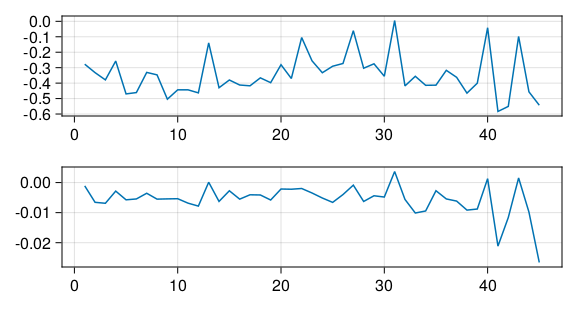

In [16]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=500, height=100)
Makie.lines!(ax, vec(cpu(adv).w[:,1]))
ax = Makie.Axis(fig[2,1], width=500, height=100)
Makie.lines!(ax, vec(q))
Makie.resize_to_layout!(fig)
fig

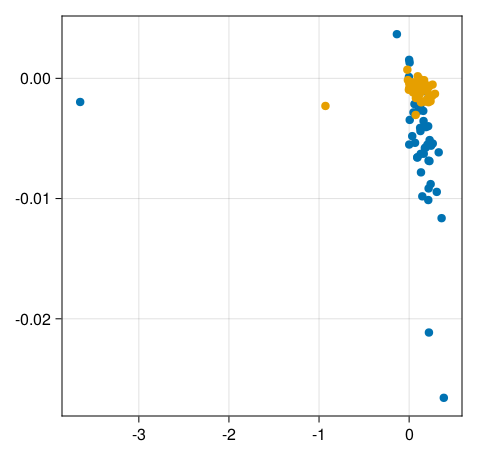

In [20]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=400, height=400)
Makie.scatter!(ax, cpu(vec(adv.w[:,1])), vec(q1))
Makie.scatter!(ax, cpu(vec(adv.w[:,2])), vec(q2))
Makie.resize_to_layout!(fig)
fig

In [21]:
#sampled_v = gpu(bitrand(size(neuron_data, 1), 1000));
sampled_v = sample_from_inputs(adv.visible, gpu(zeros(45, 5000)));
sampled_f = zeros(5000)
sampled_f[1] = mean(free_energy(adv, sampled_v))
@showprogress for t in 2:length(sampled_f)
    sampled_v .= sample_v_from_v(adv, sampled_v; steps=20)
    sampled_f[t] = mean(free_energy(adv, sampled_v))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


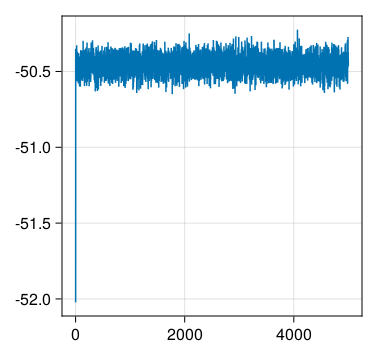

In [25]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300)
Makie.lines!(ax, sampled_f)
Makie.resize_to_layout!(fig)
fig

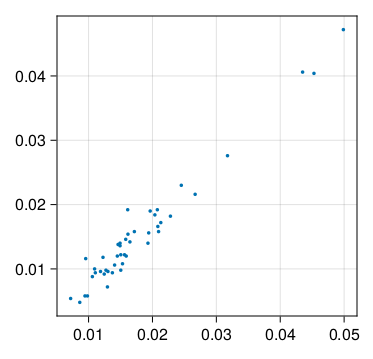

In [26]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300)
Makie.scatter!(ax,
    vec(mean(cpu(neuron_data); dims=2)),
    vec(mean(cpu(sampled_v); dims=2)),
    markersize=5
)
Makie.resize_to_layout!(fig)
fig

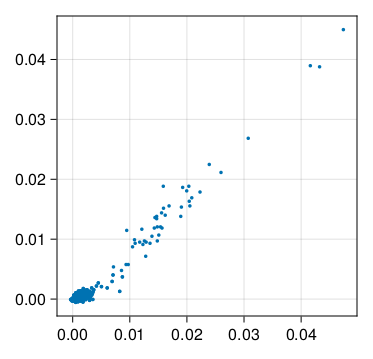

In [27]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300)
Makie.scatter!(ax,
    vec(cov(cpu(neuron_data); dims=2)),
    vec(cov(cpu(sampled_v); dims=2)),
    markersize=5
)
Makie.resize_to_layout!(fig)
fig

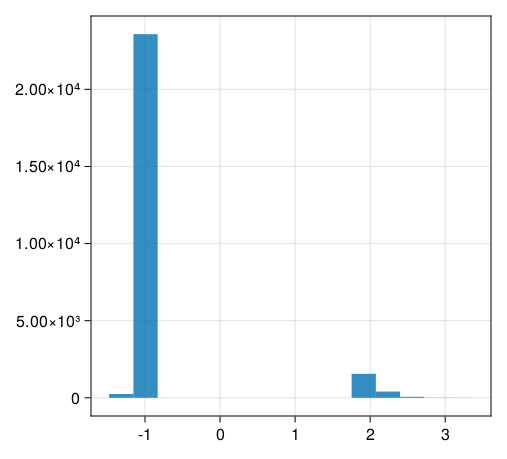

In [28]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=400, height=400)
Makie.hist!(ax, mode_h_from_v(cpu(adv), neuron_data)[1,:])
Makie.resize_to_layout!(fig)
fig

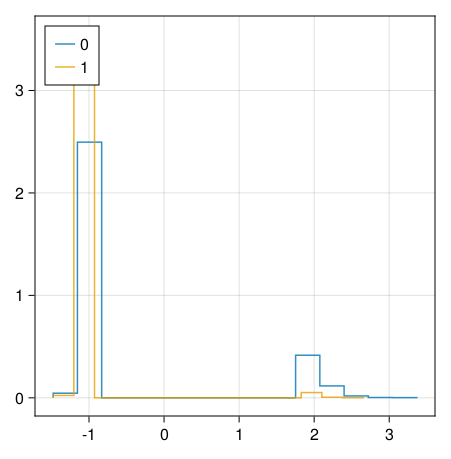

In [29]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=400, height=400)
Makie.stephist!(ax, mode_h_from_v(cpu(adv), neuron_data)[1, spontaneous_label .== 0], normalization=:pdf, label="0")
Makie.stephist!(ax, mode_h_from_v(cpu(adv), neuron_data)[1, spontaneous_label .== 1], normalization=:pdf, label="1")
Makie.axislegend(ax, position=:lt)
Makie.resize_to_layout!(fig)
fig

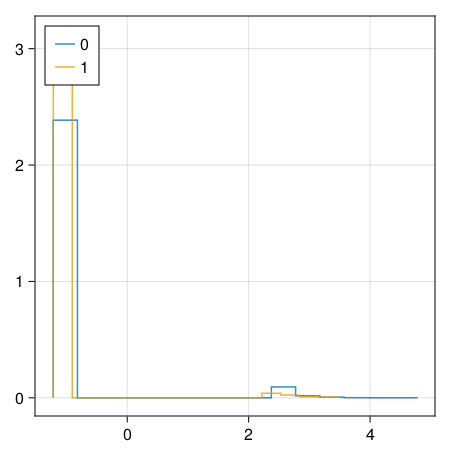

In [31]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=400, height=400)
Makie.stephist!(ax, mode_h_from_v(cpu(adv), neuron_data)[2, movement_label .== 0], normalization=:pdf, label="0")
Makie.stephist!(ax, mode_h_from_v(cpu(adv), neuron_data)[2, movement_label .== 1], normalization=:pdf, label="1")
Makie.axislegend(ax, position=:lt)
Makie.resize_to_layout!(fig)
fig